<a href="https://colab.research.google.com/github/Pranesh-VM/Phishing_website_detection_CIP/blob/main/CIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset from GitHub
url = "https://raw.githubusercontent.com/Pranesh-VM/Phishing_website_detection_CIP/main/verified_online.csv"
df_phishing = pd.read_csv(url)
df_legitimate = pd.read_csv("phishing_site_urls.csv", encoding="ISO-8859-1")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#preprocessing

# Extract relevant columns and standardize labels
phishing_urls = df_phishing[['url']].copy()
phishing_urls.rename(columns={'url': 'URL'}, inplace=True)
phishing_urls['Label'] = 'phishing'

#print("phishtank data:",len(phishing_urls.index))

# Process legitimate dataset (it contains 'good' and 'bad' labels)
df_legitimate.rename(columns={'URL': 'URL', 'Label': 'Label'}, inplace=True)
df_legitimate['Label'] = df_legitimate['Label'].map({'bad': 'phishing', 'good': 'legitimate'})

# Combine datasets
combined_df = pd.concat([phishing_urls, df_legitimate], ignore_index=True)
combined_df.drop_duplicates(subset=['URL'], inplace=True)

# Count phishing and legitimate URLs
# count_labels = combined_df['Label'].value_counts()

# print("Phishing URLs:", count_labels.get('phishing', 0))
# print("Legitimate URLs:", count_labels.get('legitimate', 0))


# Balance dataset (Ensure 1:1 ratio of phishing to legitimate URLs)
phishing_sample = combined_df[combined_df['Label'] == 'phishing']
legitimate_sample = combined_df[combined_df['Label'] == 'legitimate']

print("before unbalanced dataset:")

print("phishing samples:",len(phishing_sample))
print("legitimate samples:",len(legitimate_sample))
# Ensure equal number of phishing and legitimate URLs
min_count = min(len(phishing_sample), len(legitimate_sample))
phishing_sample = phishing_sample.sample(n=min_count, random_state=42)
legitimate_sample = legitimate_sample.sample(n=min_count, random_state=42)
print("after balancing")
print("Phishing samples:",len(phishing_sample))
print("legitmate samples:",len(legitimate_sample))
balanced_df = pd.concat([phishing_sample, legitimate_sample], ignore_index=True)

# Split dataset into Train (70%), Validation (20%), Test (10%)
train_df, temp_df = train_test_split(balanced_df, test_size=0.3, random_state=42, stratify=balanced_df['Label'])
val_df, test_df = train_test_split(temp_df, test_size=1/3, random_state=42, stratify=temp_df['Label'])

# Save preprocessed datasets
train_df.to_csv("train_set.csv", index=False)
val_df.to_csv("val_set.csv", index=False)
test_df.to_csv("test_set.csv", index=False)

print(f"Preprocessed and balanced dataset saved with training, validation, and test splits.")

# Display dataset info
display(train_df.info())
display(train_df.head())


before unbalanced dataset:
phishing samples: 177386
legitimate samples: 392897
after balancing
Phishing samples: 177386
legitmate samples: 177386
Preprocessed and balanced dataset saved with training, validation, and test splits.
<class 'pandas.core.frame.DataFrame'>
Index: 248340 entries, 26028 to 65020
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     248340 non-null  object
 1   Label   248340 non-null  object
dtypes: object(2)
memory usage: 5.7+ MB


None

,URL,Label
26028,https://docs.google.com/presentation/d/e/2PACX...,phishing
260718,academon.com/Essay-Transcontinental-Railroad/2...,legitimate
147674,https://drive-secu.myportfolio.com/,phishing
196815,linkedin.com/pub/michael-o-neal/a/319/51b,legitimate
245062,judgepedia.org/index.php/Frederic_Smalkin,legitimate


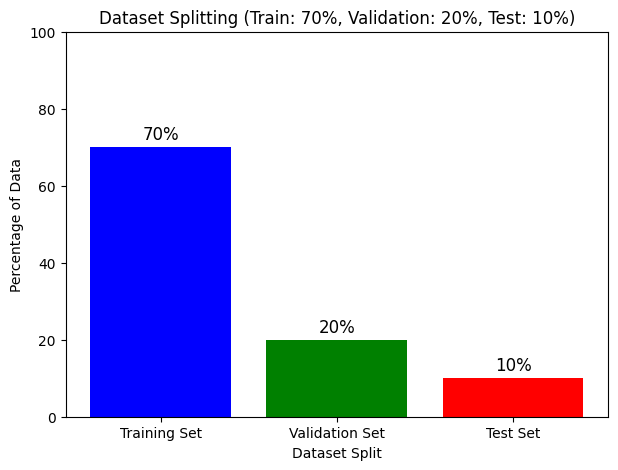

In [ ]:
import matplotlib.pyplot as plt

# Dataset split percentages
split_labels = ['Training Set', 'Validation Set', 'Test Set']
split_sizes = [70, 20, 10]  # Percentages

# Create bar chart
plt.figure(figsize=(7, 5))
plt.bar(split_labels, split_sizes, color=['blue', 'green', 'red'])

# Labels and title
plt.xlabel("Dataset Split")
plt.ylabel("Percentage of Data")
plt.title("Dataset Splitting (Train: 70%, Validation: 20%, Test: 10%)")
plt.ylim(0, 100)

# Annotate bars with percentages
for i, v in enumerate(split_sizes):
    plt.text(i, v + 2, f"{v}%", ha='center', fontsize=12)

# Show the plot
plt.show()


In [ ]:
!pip install transformers torch scikit-learn pandas networkx jieba


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import pandas as pd
import jieba
import networkx as nx
import numpy as np
import torch
from collections import defaultdict, Counter
from transformers import DistilBertTokenizer, DistilBertModel

# Load DistilBERT Tokenizer & Model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert_model = DistilBertModel.from_pretrained("distilbert-base-uncased")

# Load dataset
train_df = pd.read_csv("train_set.csv")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer

# Load the DistilBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_url(url, max_length=128):
    """
    Tokenizes the given URL using WordPiece tokenization and converts it to a fixed-length vector.

    Parameters:
    - url (str): The URL string to be tokenized.
    - max_length (int): The fixed length for padding/truncation.

    Returns:
    - token_ids (list): List of token IDs representing the URL.
    """
    # Tokenize the URL
    tokens = tokenizer.tokenize(url)

    # Convert tokens to token IDs
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    # Add special tokens [CLS] (101) and [SEP] (102)
    token_ids = [tokenizer.cls_token_id] + token_ids + [tokenizer.sep_token_id]

    # Pad or truncate to ensure fixed length
    if len(token_ids) < max_length:
        token_ids += [0] * (max_length - len(token_ids))  # Pad with 0s
    else:
        token_ids = token_ids[:max_length]  # Truncate if too long

    return token_ids

# Load the dataset (assuming the file has 'url' and 'label' columns)
df = pd.read_csv("train_set.csv")  # Replace "input.csv" with your actual file name

# Apply tokenization to the 'url' column
df['tokenized'] = df['URL'].apply(lambda x: tokenize_url(str(x)))  # Ensure string type

# Save to a new CSV file
df.to_csv("tokenized.csv", index=False)

print("Tokenization complete. File saved as tokenized.csv.")


Token indices sequence length is longer than the specified maximum sequence length for this model (649 > 512). Running this sequence through the model will result in indexing errors


Tokenization complete. File saved as tokenized.csv.


In [ ]:
import re
STOPWORDS = {"http", "https", "www", "com", "org", "net"}
def clean_url(url):
    """Remove non-alphabet characters and stopwords from URLs."""
    words = re.findall(r'[a-zA-Z]+', url.lower())
    return ' '.join([word for word in words if word not in STOPWORDS])


In [ ]:
import jieba

def tokenize_url(url):
    """
    Tokenizes the cleaned URL using Jieba tokenizer.
    """
    return list(jieba.cut(clean_url(url)))  # Convert generator to list


In [ ]:
def extract_keyword_vector(train_df):
    """Extracts top 10 phishing-related keywords using TextRank."""
    # Apply tokenization to all phishing URLs
    train_df['tokens'] = train_df['URL'].apply(tokenize_url)

    # Flatten phishing tokens
    phishing_tokens = [word for tokens in train_df[train_df['Label'] == 'phishing']['tokens'] for word in tokens]

    # Count word occurrences
    word_counts = Counter(phishing_tokens)
    filtered_words = {word for word, count in word_counts.items() if count > 1}

    # Build co-occurrence graph
    co_occurrence = defaultdict(int)
    for tokens in train_df[train_df['Label'] == 'phishing']['tokens']:
        filtered_tokens = [word for word in tokens if word in filtered_words]
        for i, word1 in enumerate(filtered_tokens):
            for word2 in filtered_tokens[i + 1:]:
                if word1 != word2:
                    co_occurrence[(word1, word2)] += 1

    G = nx.Graph()
    for (word1, word2), weight in co_occurrence.items():
        if weight > 1:
            G.add_edge(word1, word2, weight=weight)

    # Compute TextRank scores
    text_rank_scores = nx.pagerank(G, weight='weight')
    feature_library = sorted(text_rank_scores.items(), key=lambda x: x[1], reverse=True)[:10]
    feature_keywords = [word for word, _ in feature_library]

    return feature_keywords + ["0"] * (10 - len(feature_keywords))  # Ensure length 10

def embed_keywords(tokenized_vector, keywords, max_length=138):
    """Embeds the top keywords into the tokenized URL vector."""
    sep_token_id = tokenizer.sep_token_id
    if sep_token_id in tokenized_vector:
        tokenized_vector.remove(sep_token_id)

    keyword_ids = tokenizer.convert_tokens_to_ids(keywords)  # Convert keywords to token IDs
    new_vector = tokenized_vector + keyword_ids
    new_vector.append(sep_token_id)

    return new_vector[:max_length] + [0] * max(0, max_length - len(new_vector))

# Load dataset
df = pd.read_csv("train_set.csv")

# Extract top 10 keywords dynamically
top_keywords = extract_keyword_vector(df)

# Tokenize URLs using DistilBERT
de = pd.read_csv("tokenized.csv")

# Perform embedding directly on the precomputed 'tokenize' column
de['embedded'] = de['tokenized'].apply(lambda x: embed_keywords(eval(x), top_keywords, max_length=138))

# Save results
de.to_csv("embedded.csv", index=False)
print("Embedding complete. File saved as embedded.csv.")

Embedding complete. File saved as embedded.csv.


In [ ]:
ds=pd.read_csv('embedded.csv')
print(len(ds))

248340


In [ ]:
print(len(df))#verifying records in training set is matching with embedded.csv

248340


In [ ]:
ip=ds['embedded']

print(ip.sample(3))

106330    [101, 4497, 1012, 12072, 9447, 2890, 27108, 51...
99746     [101, 3617, 23099, 12789, 2140, 1012, 4012, 10...
99210     [101, 7065, 2015, 7159, 2487, 1012, 2773, 2011...
Name: embedded, dtype: object


In [ ]:
import torch
from transformers import DistilBertModel, DistilBertTokenizer
from torch.cuda.amp import autocast  # For mixed precision
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm  # For progress bar

# Load model & tokenizer
model = DistilBertModel.from_pretrained("distilbert-base-uncased").to("cuda")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Enable mixed precision
scaler = torch.cuda.amp.GradScaler()  # For FP16

# Custom Dataset for efficient batching
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])  # Ensure text is a string
        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {key: val.squeeze(0) for key, val in encoding.items()}  # Remove batch dimension

# Convert `ip` (list of URLs or texts) to a dataset
input_texts = ip.tolist()  # Convert DataFrame column to list
dataset = TextDataset(input_texts, tokenizer)

# Create DataLoader for efficient batching
batch_size = 32  # Adjust based on GPU memory
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Generate embeddings
embeddings = []
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for batch in tqdm(dataloader, desc="Generating Embeddings"):
        # Move batch to GPU
        batch = {key: val.to("cuda") for key, val in batch.items()}

        # Forward pass with mixed precision
        with autocast():
            outputs = model(**batch)

        # Extract CLS embeddings
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # (batch_size, 768)
        embeddings.append(cls_embedding.cpu())  # Move to CPU to free GPU memory

        # Clear GPU memory
        del batch, outputs, cls_embedding
        torch.cuda.empty_cache()

# Concatenate all embeddings
final_embeddings = torch.cat(embeddings, dim=0)

# Print shape
print("Final Embeddings Shape:", final_embeddings.shape)  # (num_samples, 768)

<ipython-input-24-9f0c3c05079c>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # For FP16
Generating Embeddings:   0%|          | 0/7761 [00:00<?, ?it/s]<ipython-input-24-9f0c3c05079c>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Generating Embeddings: 100%|██████████| 7761/7761 [17:11<00:00,  7.53it/s]


Final Embeddings Shape: torch.Size([248340, 768])


In [4]:
import pandas as pd

file_path = '/content/drive/MyDrive/embedded_tokenized.csv'
de = pd.read_csv(file_path)


import numpy as np

file_path = '/content/drive/MyDrive/final_embeddings.npy'  # Update with your actual file path
final_embeddings = np.load(file_path)
label_mapping = {'phishing': 1, 'legitimate': 0}
labels = de['Label'].map(label_mapping)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch [1/25] - Loss: 268.8306, Test Loss: 66.9268, Acc: 0.5021, Prec: 0.5021, Rec: 1.0000, F1: 0.6685
Epoch [2/25] - Loss: 260.8678, Test Loss: 61.3072, Acc: 0.6201, Prec: 0.6051, Rec: 0.7003, F1: 0.6493
Epoch [3/25] - Loss: 241.5189, Test Loss: 56.7188, Acc: 0.6192, Prec: 0.6180, Rec: 0.6325, F1: 0.6252
Epoch [4/25] - Loss: 228.6242, Test Loss: 54.1234, Acc: 0.6074, Prec: 0.6853, Rec: 0.4032, F1: 0.5077
Epoch [5/25] - Loss: 219.4731, Test Loss: 52.9790, Acc: 0.6128, Prec: 0.7332, Rec: 0.3595, F1: 0.4825
Epoch [6/25] - Loss: 212.4823, Test Loss: 50.6128, Acc: 0.6624, Prec: 0.6968, Rec: 0.5799, F1: 0.6330
Epoch [7/25] - Loss: 204.8150, Test Loss: 49.0822, Acc: 0.6325, Prec: 0.7752, Rec: 0.3776, F1: 0.5078
Epoch [8/25] - Loss: 197.7326, Test Loss: 47.9363, Acc: 0.6413, Prec: 0.8129, Rec: 0.3709, F1: 0.5093
Epoch [9/25] - Loss: 190.0019, Test Loss: 44.5408, Acc: 0.7151, Prec: 0.7860, Rec: 0.5943, F1: 0.6768
Epoch [10/25] - Loss: 182.5123, Test Loss: 43.0441, Acc: 0.7120, Prec: 0.7152, Rec

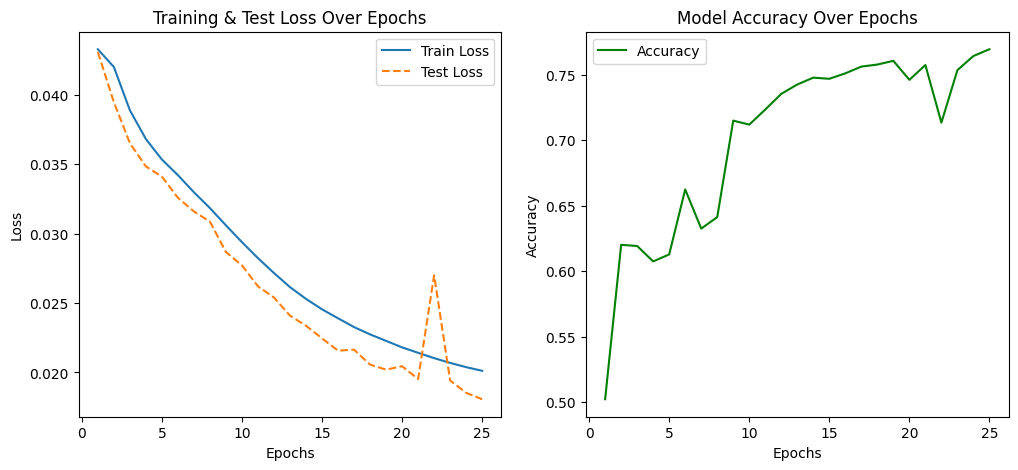

Probability: 0.233670
Legitimate


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertModel
from collections import Counter

# Load tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
d_model = DistilBertModel.from_pretrained("distilbert-base-uncased").to("cuda")

# Convert embeddings and labels to PyTorch tensors
X = torch.tensor(final_embeddings, dtype=torch.float32)
y = torch.tensor(labels.to_numpy(), dtype=torch.float32)  # Use float for Focal Loss

# Check class distribution and set weights
class_counts = Counter(y.numpy())
total_samples = sum(class_counts.values())
class_weights = torch.tensor([total_samples / class_counts[0], total_samples / class_counts[1]]).to("cuda")

# Split into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoaders
batch_size = 32
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Define CNN model
class PhishingCNN(nn.Module):
    def __init__(self):
        super(PhishingCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)  # Global Average Pooling
        self.dropout = nn.Dropout(0.5)  # Increased dropout for regularization
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()  # Sigmoid for binary classification

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x).squeeze(-1)  # Reduce last dimension after pooling
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.sigmoid(x)  # Output probability

# Initialize model
model = PhishingCNN().to("cuda")

# Define Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        BCE_loss = nn.BCELoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss.mean()

# Use Focal Loss instead of BCELoss
criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Reduced LR for stability

# Training loop
num_epochs = 25  # Increased epochs since model was improving
train_losses, test_losses, accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to("cuda"), y_batch.to("cuda")

        optimizer.zero_grad()
        outputs = model(X_batch.view(X_batch.size(0), 1, 768))
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    # Evaluate on test set
    model.eval()
    y_pred, y_true = [], []
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to("cuda"), y_batch.to("cuda")
            outputs = model(X_batch.view(X_batch.size(0), 1, 768)).squeeze()
            test_loss += criterion(outputs, y_batch).item()
            y_pred.extend(outputs.cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())

    test_losses.append(test_loss / len(test_loader))

    # Convert probabilities to binary predictions
    y_pred = [1 if p > 0.5 else 0 for p in y_pred]

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss:.4f}, Test Loss: {test_loss:.4f}, Acc: {accuracy:.4f}, Prec: {precision:.4f}, Rec: {recall:.4f}, F1: {f1:.4f}")

print("Training complete!")

# Plot Loss and Accuracy Graph
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), test_losses, label="Test Loss", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Test Loss Over Epochs")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), accuracies, label="Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.legend()

plt.show()

# Prediction function


# Example usage
  # Replace with actual URL

In [7]:
def predict_url(url):
    encoding = tokenizer([url], padding=True, truncation=True, return_tensors="pt").to("cuda")

    # Extract mean of all token embeddings
    with torch.no_grad():
        output = d_model(**encoding)
    embedding = output.last_hidden_state.mean(dim=1).unsqueeze(1)

    # Pass through CNN
    with torch.no_grad():
        prediction = model(embedding.to("cuda"))

    # Convert to probability
    probability = prediction.item()

    print(f"Probability: {probability:.6f}")

    return "Phishing" if probability < 0.5 else "Legitimate"

In [8]:
print(predict_url("http://secure-login.com"))

Probability: 0.233670
Phishing
